Student Details

Name: Abhijit Sinha

ID: 18195067

# Etivity5: Feature Selection 

This notebook builds on top of Lab 4 by introducing feature selection into the process of selecting the best classifier for a binary classification problem.

The feature selection method applied here is Recursive Feature Elimination (RFE) as demonstrated in the tutorial at https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/.

In this demonstration we use a modified version of the seeds data set (see https://archive.ics.uci.edu/ml/datasets/seeds), which is the same data set used in Lab 4.

## A. Preparation

### Import Python modules

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing #needed for scaling attributes to the interval [0,1]

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Using a global random seed for reproducible results when doing multiple runs
np.random.seed(5)

# Task 1
Repeat the experiment in Etivity5-Feature Selection.ipynb with winequality_red.csv and draw initial conclusions from the results you observe.

### Load and prepare the dataset for training and evaluation
Feel free to apply any other pre-processing technique at this point.

In [2]:
lab5_df = pd.read_csv("./winequality_red.csv")
lab5_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [3]:
lab5_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
lab5_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
lab5_df.shape

(1599, 12)

In [6]:
# target attribute
target_attribute_name = 'quality'
target = lab5_df[target_attribute_name]

# predictor attributes
predictors = lab5_df.drop(target_attribute_name, axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

### Target analysis 

In [7]:
# Check the target variables unique values
target.unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

Target is multi-class as it has a value in the range of 3 to 8.

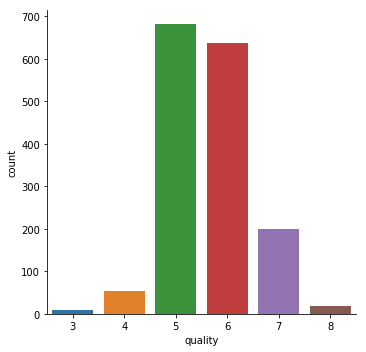

In [8]:
# show the number of observations in each target category
sns.catplot(x="quality", kind="count", data=lab5_df);

Split the data set into a training (80%) and test (20%) data sets.

In [9]:
# pepare independent stratified data sets for training and test of the final model
predictors_train, predictors_test, target_train, target_test = train_test_split(
    predictors, target, test_size=0.20, shuffle=True, stratify=target)

print(predictors_train.shape, predictors_test.shape, target_train.shape, target_test.shape)

(1279, 11) (320, 11) (1279,) (320,)


## B. Feature Selection

#### 1. Apply RFE with SVM for selecting the best features

In [10]:
# create a base classifier used to evaluate a subset of attributes
estimatorSVM = svm.SVR(kernel="linear")
selectorSVM = RFE(estimatorSVM, 3)
selectorSVM = selectorSVM.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorSVM.support_)
print(selectorSVM.ranking_)

[False  True False False False False False False False  True  True]
[3 1 9 5 2 7 6 4 8 1 1]


#### 2. Apply RFE with Logistic Regression for selecting the best features

In [11]:
# create a base classifier used to evaluate a subset of attributes
estimatorLR = LogisticRegression()
# create the RFE model and select 3 attributes
selectorLR = RFE(estimatorLR, 3)
selectorLR = selectorLR.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorLR.support_)
print(selectorLR.ranking_)

[False  True False False False False  True False False False  True]
[6 1 4 9 8 5 1 3 7 2 1]


## B. Evaluate on the Test Data Set

Apply the selectors to prepare training data sets only with the selected features

__Note:__ The same selectors are applied to the test data set. However, it is important that the test data set was not used by (it's invisible to) the selectors. 

In [12]:
predictors_train_SVMselected = selectorSVM.transform(predictors_train)
predictors_test_SVMselected = selectorSVM.transform(predictors_test)

In [13]:
predictors_train_LRselected = selectorLR.transform(predictors_train)
predictors_test_LRselected = selectorLR.transform(predictors_test)

### Train and evaluate SVM classifiers with both the selected features and all features 

Here we train three models:
* model1 - with the features selected by SVM
* model2 - with the features selected by Logistic Regression
* model3 - with all features (i.e. without feature selection)

In [14]:
classifier = svm.SVC()

In [15]:
model1 = classifier.fit(predictors_train_SVMselected, target_train)
model1.score(predictors_test_SVMselected, target_test)

0.5875

In [16]:
model2 = classifier.fit(predictors_train_LRselected, target_train)
model2.score(predictors_test_LRselected, target_test)

0.609375

In [17]:
model3 = classifier.fit(predictors_train, target_train)
model3.score(predictors_test, target_test)

0.603125

## C. Initial conclusions from the results:

The results above, give evidence that **model2, which is features selected by Logistic Regression, ** is most accurate. However, when you execute this code again, it is very likely to get different results

# Task 2
- Repeat the experiment in Etivity5-Feature Selection.ipynb with winequality_red.csv
- Run the whole experiment in a loop with different training/test stratified splits. 
- Evaluate the three models for each iteration of the loop separately and boxplot the accuracies of the models for each iteration. 
- Compare the results of this experiment to the results of Task 1 in a markdown cell (max 150 words).


Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

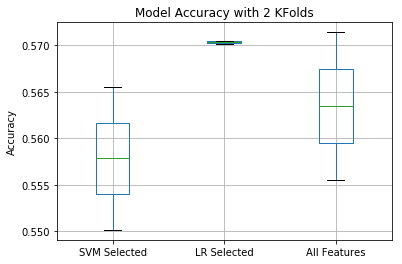

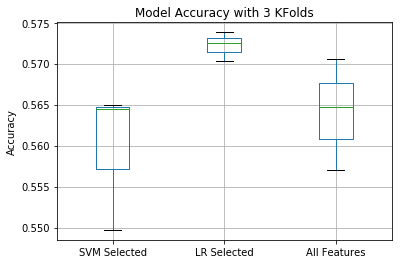

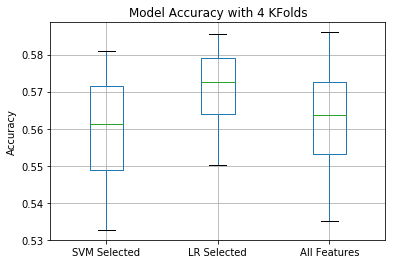

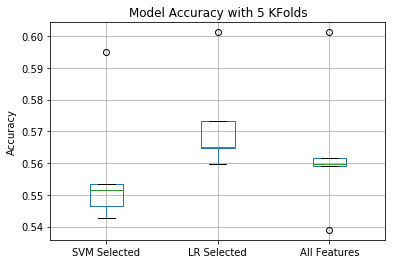

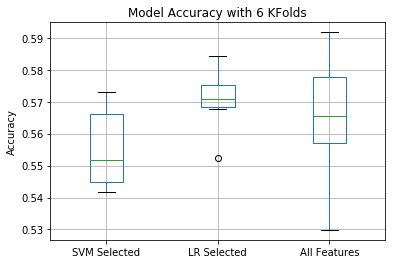

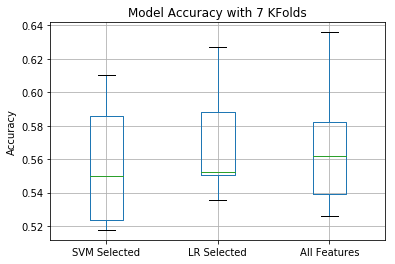

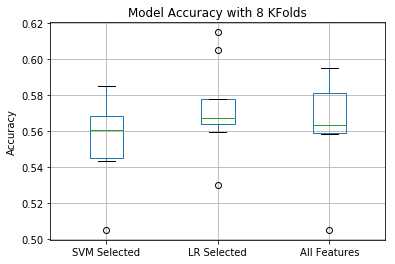

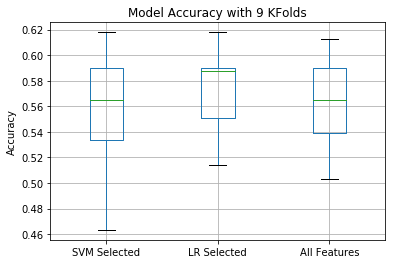

In [18]:
# Store the values of predictors to X and target to y
X = predictors
y = target

# Set the number of folds
min_fold = 2
max_fold = 10

# Create the base SVC classifier
svc_classifier = svm.SVC()

# Run the whole experiment in a loop with different training/test stratified splits
for fold in range(min_fold, max_fold):
    model1_score = []
    model2_score = []
    model3_score = []

    # Select different training/test using Stratified K-Folds cross-validator for stratified splits
    skf = StratifiedKFold(n_splits=fold, shuffle=True)
    skf.get_n_splits(X, y)
    
    for train_index, test_index in skf.split(X, y):

        X_train, X_test = predictors[train_index], predictors[test_index]
        y_train, y_test = target[train_index], target[test_index]

        X_train_SVMselected = selectorSVM.transform(X_train)
        X_test_SVMselected = selectorSVM.transform(X_test)

        X_train_LRselected = selectorLR.transform(X_train)
        X_test_LRselected = selectorLR.transform(X_test)

        model1 = svc_classifier.fit(X_train_SVMselected, y_train)
        model1_score.append(model1.score(X_test_SVMselected, y_test))
        
        model2 = svc_classifier.fit(X_train_LRselected, y_train)
        model2_score.append(model2.score(X_test_LRselected, y_test))
        
        model3 = svc_classifier.fit(X_train, y_train)
        model3_score.append(model3.score(X_test, y_test))

    # Store the model scores in a pandas dataframe
    accuracy_df = pd.DataFrame({'SVM Selected': model1_score,
                                'LR Selected' : model2_score,
                                'All Features': model3_score
                               })
    
    # Box plot the score for each model per Stratified fold
    accuracy_df.boxplot()
    plt.title("Model Accuracy with {} KFolds".format(fold))
    plt.ylabel("Accuracy")
    plt.show()

### Observation:
The variance of model2 is comparatively lower than the other 2 models.

# Task 3
Build two pipelines for training classifiers for the dataset winequality_red.csv and summarise the results from training classifiers with the pipelines in a markdown cell (max 150 words). 

The two pipelines should include feature-selection methods, and the feature-selection method in pipeline 1 should be different from the feature-selection method in pipeline 2.

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# create feature union
features = []
#features.append(('pca', PCA(n_components=3)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)

# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic', svm.SVC()))
model = Pipeline(estimators)

# evaluate pipeline
seed = 7
kfold = StratifiedKFold(n_splits=10, random_state=seed)
results = cross_val_score(model, X, y, cv=kfold)
print(results.mean())

0.5667570411997901


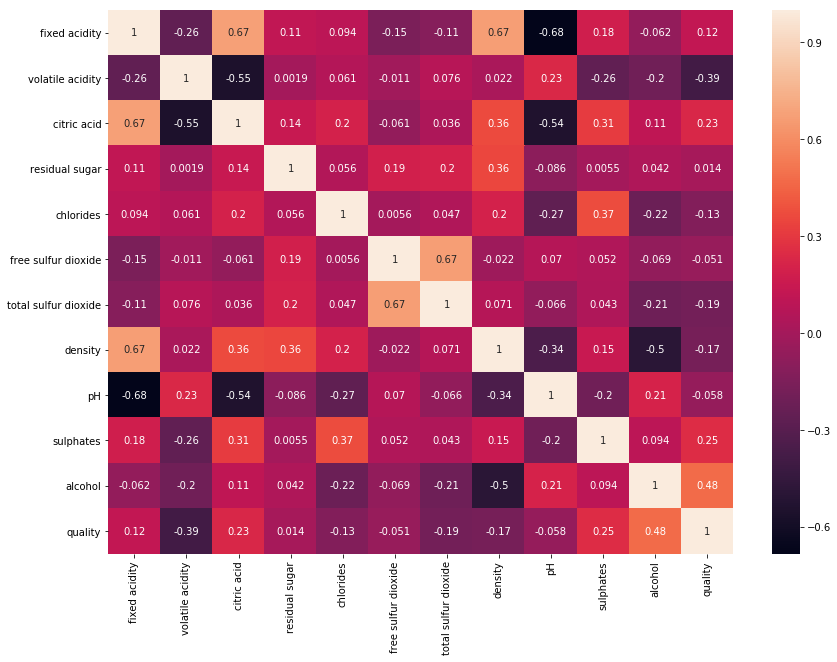

In [36]:
corr = lab5_df.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True)